In [6]:
import torch
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import cv2, random, os
import detectron2
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from time import time 
#setup logger
from detectron2.utils.logger import setup_logger
setup_logger()

from google.colab.patches import cv2_imshow

/home/sc.uni-leipzig.de/au261fala/anaconda3/envs/detectron/lib/python3.9/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [7]:
# ransac libraries
from skimage.measure import LineModelND, ransac
from sklearn import linear_model
import numpy as np
import math
import statistics
import matplotlib.path as mplPath
from shapely.geometry import Polygon as sPoly

In [10]:
#parameters for Detectron net
MetadataCatalog.get("test_set").set(thing_classes=['fenster', 'haustuer', 'gaube', 'shop', 'dachfenster'])
train_metadata = MetadataCatalog.get("test_set")

In [14]:
#load detectron model
new_cfg = get_cfg()
if not torch.cuda.is_available():
    print('not using gpu acceleration')
    new_cfg.MODEL.DEVICE = 'cpu'
new_cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
new_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

new_cfg.MODEL.WEIGHTS = "train_mixed_b-400_LR0018_BS1024_MAXITER6339.pth"
new_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85  # set a custom testing threshold
predictor = DefaultPredictor(new_cfg)
window_class = 0
gauben_class = 2
dachfenster_class = 4

## Ransac parameters

In [15]:
window_size_factor = 1.4
slope_factor = 1.4

thresh_slope_deviation = 0.0015
repeat_slope = 0.025

# on uneven iteration
window_size_grow = 1.15
slope_shrink = 0.97

In [30]:
# debug configuration, set True

In [32]:
show_plots = False # True False
verbose = False

In [26]:
# helperfuncs for debug / verbose = True 
def plot_centroids(points, imgfilepath):
    if not show_plots:
        return
    plt_im = plt.imread(imgfilepath)
    im_height, im_width, channels = plt_im.shape
    data = np.c_[points, 0:len(points)]
    x = data[:, 0]
    y = data[:, 1] 
    plt.figure()
    plt.ylim((0,im_height))
    plt.gca().invert_yaxis()
    

    plt.plot(x, y, 'r.', markersize=10)
    plt.show()
    
def plot_centroids_on_img(points, imgfilepath, color):
    if not show_plots:
        return
    plt_im = plt.imread(imgfilepath)
    im_height, im_width, channels = plt_im.shape
    fig, ax = plt.subplots()
    plt_im = ax.imshow(plt_im)
    
    data = np.c_[points, 0:len(points)]
    x = data[:, 0]
    y = data[:, 1]
    plt.ylim((0,im_height))
    plt.gca().invert_yaxis()
    plt.plot(x, y, color=color, marker='.', markersize=10)
    plt.show()
    

def plot_window_on_img(window_pts, points, imgfilepath, color):
    if not show_plots:
        return
    plt_im = plt.imread(imgfilepath)
    im_height, im_width, channels = plt_im.shape
    fig, ax = plt.subplots()
    plt_im = ax.imshow(plt_im)
    
    data = np.c_[points, 0:len(points)]
    x = data[:, 0]
    y = data[:, 1]
    plt.ylim((0,im_height))
    plt.xlim(0, im_width)
    plt.gca().invert_yaxis()
    plt.plot(x, y, color=color, marker='.', markersize=10)
    ax.add_patch(
        Polygon(window_pts, color='forestgreen', alpha=0.5)
    )
    plt.show()

    
def plot_floor_level_lines(imgfilepath, lines):
    colors = ['red','blue','green', 'orchid', 'yellow', 'magenta', 'cyan', 'pink', 'navy', 'olive', 'coral', 'sienna', 'salmon', 'orchid', 'aqua', 'blue', 'red']
    plt_im = plt.imread(imgfilepath)
    fig, ax = plt.subplots()
    plt_im = ax.imshow(plt_im)

    slopes = get_slopes_for_lines(lines)

    for i, line in enumerate(lines):

        data = np.c_[line, 0:len(line)]
        x = data[:, 0]
        y = data[:, 1] 
        plt.plot(x, y, color=colors[i], markersize=14)

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

### Code

In [17]:
# - for detection of attic floors -
def convert_dimension_for_shapely(box):

    ul = [box[0], box[1]]
    ur = [box[2], box[1]]
    lr = [box[2], box[3]]
    ll = [box[0], box[3]]
    temp = [ul, ur, lr, ll]
    temp = np.array(temp)
    return temp


def check_for_gaube(outputs, gauben_class):
    if outputs['instances'][outputs['instances'].pred_classes == gauben_class]:
        return True
    else: 
        return False
    
    
def check_if_gaube_contains_window(box_window, box_gaube):  
    #generate polygons and check if the window box is contained by the gaube box
    window = sPoly(box_window)
    gaube = sPoly(box_gaube)
    
    if window.intersects(gaube) or gaube.contains(window) or gaube.intersects(window):
        return True
    else:
        return False  
    
# for big gauben, detectron may also detect a window inside a gaube leading to a wrong count of floors. 
# this methods checks, if a windows is contained inside the bounding box of a gaube
# PARAMS:
# all_windows: np array of bboxes of all windows
# all_gauben: np array of bboxes of all gauben
# RETURNS:
# True if window is inside gaube, else False
def check_for_overlapping_window_in_gaube(all_windows, all_gauben):
    
    for gaube in all_gauben:
        conv_gaube = convert_dimension_for_shapely(gaube)
        for window in all_windows:
            conv_window = convert_dimension_for_shapely(window)
            if check_if_gaube_contains_window(conv_gaube, conv_window):
                return True
    return False

In [18]:
# calculate average height of bboxes of windows
# PARAMS: 
#  bboxes (nparray) 2D
# RETURNS:
# avg (int) of box height
def calculate_avg_bbox_height(bboxes):
    heights = []
    for bbox in bboxes:
        height = bbox[3] - bbox[1]
        heights.append(height)
    avg = sum(heights) / len(heights)
    max_height = max(heights)
    median = statistics.median(heights)
    
    if verbose:
        print(f"MEDIAN BOX HEIGHT: {median}")
        print(f"MAX BOX HEIGHT: {max_height}")
        print(f"AVG BOX HEIGHT: {avg}")
    return int(avg)
    #return int(max_height)
    
# get the upper points of the window bounding boxes to feed into RANSAC
# PARAMS:
#  bboxes (nparray)2d returned from Detectron
# RETURNS:
# upper_points (list) of points
def get_upper_points_of_bbox(bboxes):
    upper_points = []
    for item in bboxes:
        first = [item[0], item[1]]
        second = [item[2], item[1]]
        upper_points.append(first)
        upper_points.append(second)
    return upper_points


# helper function to add "fake points" if only one window was found, because RANSAC needs more than two points
# ghost points are placed between the two "real points"
# PARAMS:
#  window: (nparray) the points from image that lie in this window
# RETURNS: 
# window: (nparray) same window with ghost points
def add_ghost_points(window):
    temp_win = window.tolist()
    
    first_new_point = [temp_win[0][0] + 5, temp_win[0][1]]
    last_new_point = [temp_win[1][0] - 5, temp_win[1][1]]
    temp_win.extend([first_new_point, last_new_point])
    window = np.array(temp_win)
    window = window[window[: ,0].argsort()]
    return window

In [19]:
# for each line, calculate the slope the line has between first and last points
# PARAMS:
# linepts (list) of points in one line
# RETURNS:
# slope (float) if line existed
def calculate_slope(linepts):
    if len(linepts) > 0:
        first_pt = linepts[0]
        last_pt = linepts[-1]
        x1, y1 = first_pt[0], first_pt[1]
        x2, y2 = last_pt[0], last_pt[1]
        
        if (x2 - x1 != 0):
            return (y2 - y1) / (x2 - x1);
    
    else:
        return "ERROR"

    
# calc avg slope value for any slopes dict
# PARAMS:
# slopes (dict) of slope:line
# RETURNS:
# avg_slope (float) for all slopes in slopes
def calculate_avg_slope(slopes):
  
    num_items = len(slopes)
    if 0.0 in slopes and len(slopes[0.0]) > 1:
        num_items = len(slopes) + len(slopes[0.0])-1
            
    avg_slope = sum(slopes)/num_items
    if verbose:
        print(f"avg slope: {avg_slope}")

    return avg_slope


# calc median slope value for any slopes dict
# PARAMS:
# slopes (dict) of slope:line
# RETURNS:
# median_slope (float) for all slopes in slopes
def calculate_median_slope(slopes):
  
    all_slopes = list(slopes.keys())
    if 0.0 in slopes and len(slopes[0.0]) > 1:
        i = 0
        for i in range(len(slopes[0.0])-1):
            all_slopes.append(0.0)
            
    median_slope = statistics.median(all_slopes)
    if verbose:
        print(f"median slope: {median_slope}")
    return median_slope
    
    
# helper function for generating uneven window: calculate y-value of line for window
def calculate_y_val(m, x, b):
    y = m*x+b
    return y


# iterate all found lines and calculate their slope
# PARAMS: lines: list of points
# RETURNS: slopes : dict of slope:line
#          if slope== 0.0, value of dict is list of lines, else (slope,line)
def get_slopes_for_lines(lines):
    slopes = dict()
    for i, line in enumerate(lines):
        slope = calculate_slope(line)
        if verbose:
            print(slope)
        if slope == 0.0:
            if slope in slopes.keys():
                slopes[slope].append(line)
            else:
                slopes[slope] = [line]
        else:
            slopes[slope] = line
    return slopes


# calculate the deviation of each slope from the median slope, keep only slopes within a threshold of the median slope
# PARAMS:
# median_slope: (float) of the run before
# slopes: (dict) slope,line of the run before
# dev_thresh (float) threshold value that a slope should not deviate from the mean slope
# RETURNS:
# new_median_slope (float) of filtered slopes
# filtered_slopes (dict) of filtered slopes
def filter_on_deviation_from_mean_slope(median_slope, slopes, dev_thresh):
    
    if verbose: 
        print("filter on deviation from slope")
        print(['{} - {:.20f}'.format(slope, pow(abs(slope - median_slope),2)) for slope in slopes.keys()])
    
    filtered_slopes = dict()
    for slope,line in slopes.items():

        deviation_from_mean = pow(abs(slope - median_slope),2)
        if deviation_from_mean < dev_thresh:
            filtered_slopes[slope] = line
            
    # calc median slope
    if len(filtered_slopes) > 0:
        new_med_slope = calculate_median_slope(filtered_slopes)    
        return new_med_slope, filtered_slopes

    else:
        
        return 0, 0
    
    
# filter out lines that have opposing slope direction
# PARAMS:
# slopes: all slopes (dict of slope:line)
# filtered_slopes: (dict) only the slopes to be left after filtering
# RETURNS:
# filtered_lines: list of lines
def filter_lines_with_slopes(slopes, filtered_slopes):
    if 0.0 not in slopes.keys():
        filtered_lines = [slopes[slope] for slope in filtered_slopes]
        return filtered_lines
    else:
        filtered_lines = []
        for slope in filtered_slopes.keys():
            if slope == 0.0:
                temp_lines = [line for line in filtered_slopes[0.0]]
                filtered_lines.extend(temp_lines)
            else:
                filtered_lines.append(filtered_slopes[slope])
        return filtered_lines

## RANSAC

In [20]:
# implementation of RANSAC to detect lines in the points of windows
#PARAMS:
# input_points (nparray) of the points from windows
# img_filepath: String ONLY USED FOR DEBUGGING (plotting on image) - REMOVE in PRODUCTION
# res_thresh: RANSAC threshold how strict the algo is about outliers (the higher the less strict)
#RETURNS:
# sorted_inliers (list) of all approved points
# outliers (list) of all discarded points
def detect_lines(input_points, img_filepath, res_thresh):

    if verbose == True:
        print(f"input of method: detect_lines, {len(input_points)}") #items:\n {input_points}

    # robustly fit line only using inlier data with RANSAC algorithm
    model_robust, inliers = ransac(input_points, LineModelND, min_samples = 2,
                                   residual_threshold=res_thresh, max_trials=700)
    result_inliers = []
    outliers = []
    
    for i in range(0,len(input_points)):

        if (inliers[i] == False):
            #Not an inlier
            outliers.append((input_points[i][0], input_points[i][1]))
            continue
        x=input_points[i][0]
        y=input_points[i][1]
        result_inliers.append((x,y))
    
    # inliers sorted by x-value
    sorted_inliers = sorted(result_inliers, key= lambda x: x[0])
    
    if verbose:
        print(f"# outliers: {len(outliers)}, outliers: \n {outliers}")
        print(f"# inliers: {len(result_inliers)}, inliers: \n {result_inliers}")
        plot_centroids_on_img(result_inliers, img_filepath, 'green')
        print("----------------")

    return sorted_inliers, outliers


# check all detected lines if two lines should actually be combined to one
# detected_lines needs to be sorted!!!
# PARAMS:
# detected_lines (list) of all RANSAC detected lines
# RETURNS:
# new_lines: (list) of merged lines 
def check_for_same_floor_lines(detected_lines):
    
    new_lines = []
    index = 0
    
    while index < len(detected_lines):

        try:
            temp = np.array(detected_lines[index] + detected_lines[index+1])
            if len(temp) == 2:
                 temp = add_ghost_points(np.array(temp))
                
            temp_inliers, temp_outliers = detect_lines(temp, imgfilepath, 20)
            # wasn't same line
            if len(temp_outliers) >= 2:
                new_lines.append(detected_lines[index])
                plot_centroids_on_img(detected_lines[index], imgfilepath, 'blue')
                index += 1
            # was same line
            else:
                new_lines.append([(temp_inliers[i][0], temp_inliers[i][1]) for i in range(0,len(temp_inliers))])
                plot_centroids_on_img([(temp_inliers[i][0], temp_inliers[i][1]) for i in range(0,len(temp_inliers))], imgfilepath, 'yellow')
                index += 2
        # only one line left
        except IndexError:
            last = detected_lines[index]
            if len(last) == 2:
                 last = add_ghost_points(np.array(last))
            temp_inliers, temp_outliers = detect_lines(np.array(last), imgfilepath, 20)
            if len(temp_outliers) >= 2:
                new_lines.append(detected_lines[index])
                plot_centroids_on_img(detected_lines[index], imgfilepath, 'blue')
            else:
                new_lines.append([(temp_inliers[i][0], temp_inliers[i][1]) for i in range(0,len(temp_inliers))])
                plot_centroids_on_img([(temp_inliers[i][0], temp_inliers[i][1]) for i in range(0,len(temp_inliers))], imgfilepath, 'yellow')
            break
    return new_lines

In [21]:
#Calculates the next window for iteration
def calculate_next_window(window_upper_range, window_size, slope, x_max, is_uneven_window):
    
    window_lower_range = window_upper_range 
    window_upper_range = window_lower_range + window_size
    
    y1_lower = window_lower_range
    y1_upper = window_upper_range
    
    if is_uneven_window:
        y2_lower, y2_upper = calculate_y_val(slope, x_max, y1_lower), calculate_y_val(slope, x_max, y1_upper)
    else:
        y2_lower, y2_upper = y1_lower, y1_upper
    
    return window_lower_range, window_upper_range, y1_lower, y1_upper, y2_lower, y2_upper


# detectron has inverted y - axis!!
# iterate an image in horizontal "windows" because otherwise RANSAC will also choose vertical lines
# on first iteration window is even and slope is 0, on following iterations these variables are calculated from the run before
# PARAMS:
# img_path (String): filepath to image
# window_upper_pts: (np array) upper left and right point of each detected window
# window_size: (int) average window size calculated from boxes
# slope: (float) slope of lines from run before to create uneven window with
# uneven_window (bool): in first run false, otherwise true
# window_radius (int): matplotlib variable to deal with point lying on the edges of window
# RETURNS:
# lines: (list) of lines for floors
# sortedout_lines (list) of lines that have been marked as outliers
def split_image_with_window(img_path, window_upper_pts, window_size, slope, is_uneven_window, window_radius, window_size_grow, slope_shrink):
    im = cv2.imread(img_path)
    img_height, img_width, channels = im.shape

    lines = []
    sortedout_lines = []
    sorted_window_pts = window_upper_pts[window_upper_pts[:, 1].argsort()]
    
    # set the window for iteration
    max_y_val = img_height
    x_min = 0
    x_max = img_width
    
    # ranges define the even window from which the uneven window is calculated
    window_lower_range = math.floor(np.amin(sorted_window_pts[:, 1]))
    if is_uneven_window:
        window_lower_range = window_lower_range - 75   
    window_upper_range = window_lower_range + window_size
    
    y1_lower, y1_upper = window_lower_range, window_upper_range
    if is_uneven_window:
        y2_lower, y2_upper = calculate_y_val(slope, x_max, window_lower_range), calculate_y_val(slope, x_max, window_upper_range)
  
    else:
        y2_lower, y2_upper = window_lower_range, window_upper_range
    
 
    while window_upper_range <= max_y_val:
        if verbose:
            print(f"window range: {window_lower_range, window_upper_range}, max_val: {max_y_val}, window size: {window_size}")
        
        window_array= np.array([[x_min, y1_lower],
                                    [x_min, y1_upper],
                                    [x_max, y2_upper],
                                    [x_max, y2_lower]])
        
        window_poly = mplPath.Path(window_array)
        pts_in_window = np.array([item for item in sorted_window_pts if window_poly.contains_point(item, radius= window_radius)])
        
        plot_window_on_img(window_array, pts_in_window, img_path, 'red')
        
        window_size = window_size * window_size_grow
        slope = slope * slope_shrink
        
        if len(pts_in_window) < 2:
            window_lower_range, window_upper_range, y1_lower, y1_upper, y2_lower, y2_upper = calculate_next_window(window_upper_range, window_size, slope, x_max, is_uneven_window)
            continue
            
        if len(pts_in_window) == 2:
        
            ghost_pts_in_window = add_ghost_points(pts_in_window)
            inliers, outliers = detect_lines(ghost_pts_in_window, img_path, 10)
            lines.append([inliers[0], inliers[-1]])
            sortedout_lines.append(outliers)
            window_lower_range, window_upper_range, y1_lower, y1_upper, y2_lower, y2_upper = calculate_next_window(window_upper_range, window_size, slope, x_max, is_uneven_window)
            continue

        else:
            inliers, outliers = detect_lines(pts_in_window, img_path, 10)
            lines.append(inliers)
            sortedout_lines.append(outliers)
            window_lower_range, window_upper_range, y1_lower, y1_upper, y2_lower, y2_upper = calculate_next_window(window_upper_range, window_size, slope, x_max, is_uneven_window)

            
            
    # run the last window
    y1_lower, y1_upper = window_lower_range, max_y_val
    if is_uneven_window:
        y2_lower, y2_upper = calculate_y_val(slope, x_max, y1_lower), calculate_y_val(slope, x_max, y1_upper)
    else:
        y2_lower, y2_upper = y1_lower, y1_upper
    if verbose:
        print(f"last window range: {y1_lower, max_y_val}, max_val: {max_y_val}")
    window_array= np.array([[x_min, y1_lower],
                                    [x_min, y1_upper],
                                    [x_max, y2_upper],
                                    [x_max, y2_lower]])  
    window_poly = mplPath.Path(window_array)
    pts_in_window = np.array([item for item in sorted_window_pts if window_poly.contains_point(item, radius= window_radius)])
    plot_window_on_img(window_array, pts_in_window, img_path, 'red')
    
    if len(pts_in_window) < 2:
        return lines, sortedout_lines
    
    if len(pts_in_window) == 2:
        
        ghost_pts_in_window = add_ghost_points(pts_in_window)
        inliers, outliers = detect_lines(ghost_pts_in_window, img_path, 10)
        lines.append([inliers[0], inliers[-1]])
        sortedout_lines.append(outliers)
    else:
        if verbose:
            print(window_upper_range, max_y_val)
        inliers, outliers = detect_lines(pts_in_window, img_path, 10)
        lines.append(inliers)
        sortedout_lines.append(outliers)

    return lines, sortedout_lines 
    

In [22]:
def predict_facade_elements(imgfilepath, predictor, window_class):
    im = cv2.imread(imgfilepath)
    if im is None:
        return [],[],[]
    outputs = predictor(im)
    
    if verbose:
        print(outputs)
   
    if show_plots:
        v = Visualizer(im[:, :, ::-1],
                       metadata=train_metadata, 
                       scale=0.5, 
                       #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        cv2_imshow(out.get_image()[:, :, ::-1])
        
    bboxes = outputs['instances'][outputs['instances'].pred_classes == window_class].pred_boxes
    bbox_centers = bboxes.get_centers().cpu().numpy()
    bboxes = outputs['instances'][outputs['instances'].pred_classes == window_class].pred_boxes.tensor.cpu().numpy()
    
    return bboxes, outputs, bbox_centers

In [36]:
def calculate_num_floors(outputs, lines, window_class, gauben_class, dachfenster_class):

    # check for Gaube 
    num_floors = len(lines)
    if check_for_gaube(outputs, gauben_class):

        windows = outputs['instances'][outputs['instances'].pred_classes == window_class].pred_boxes.tensor.cpu().numpy()
        gauben = outputs['instances'][outputs['instances'].pred_classes == gauben_class].pred_boxes.tensor.cpu().numpy()
    
        if check_for_overlapping_window_in_gaube(windows, gauben):
            num_floors = str(num_floors-1) + " + attic"
        else:
            num_floors = str(num_floors) + " + attic"
            
    # check for dachfenster
    elif outputs['instances'][outputs['instances'].pred_classes == dachfenster_class]:
        num_floors = str(num_floors) + " + attic"
        
    if verbose: 
        print(f" building has {num_floors} floors.")
    return num_floors

# RUN

In [34]:
def run_ransac_in_notebook(image_path, window_class, gauben_class, dachfenster_class):
    bboxes, outputs, bbox_centers = predict_facade_elements(image_path, predictor, window_class)
    #if no windows were detected
    if len(bboxes) == 0:
        return 0, []
 
   
    avg_box_height = calculate_avg_bbox_height(bboxes)
    upper_points = get_upper_points_of_bbox(bboxes)

    lines, sortedout_lines = split_image_with_window(image_path, np.array(upper_points), window_size_factor*avg_box_height, 0, False, 0, window_size_grow, slope_shrink)
    outlier_ratio = (len(sum(sortedout_lines, []))/len(sum(lines, []))*100)
    
    #if no lines were detected
    if len(lines) == 0:
        return 0, []
 
    # calculate from first run
    slopes = get_slopes_for_lines(lines)
    median_slope = calculate_median_slope(slopes)

    # filter out slopes that deviate from mean slope
    median_slope_filtered, filtered_slopes = filter_on_deviation_from_mean_slope(median_slope, slopes, thresh_slope_deviation)
    if median_slope_filtered == 0 and filtered_slopes == 0:
        median_slope_filtered = median_slope
        filtered_lines = lines
    else:
        filtered_lines = filter_lines_with_slopes(slopes, filtered_slopes)

    # merge lines that are in the same floor
    merged_lines = check_for_same_floor_lines(filtered_lines)
    slopes = get_slopes_for_lines(merged_lines)
    
    median_slope_merged, filtered_slopes = filter_on_deviation_from_mean_slope(median_slope_filtered, slopes, thresh_slope_deviation)
        #add abs??
    if median_slope_merged > repeat_slope or outlier_ratio > 50:
        if verbose:
            print(f"SECOND RUN, NUM LINES FIRST RUN: {len(merged_lines)}")
        lines, sortedout_lines = split_image_with_window(image_path, np.array(upper_points), window_size_factor*avg_box_height, slope_factor*median_slope_merged, True, 0, window_size_grow, slope_shrink)
        if len(lines) == 0:
            return 0
        
        slopes = get_slopes_for_lines(lines)
        median_slope = calculate_median_slope(slopes)

        median_slope_filtered, filtered_slopes = filter_on_deviation_from_mean_slope(median_slope, slopes, thresh_slope_deviation)
        if median_slope_filtered == 0 and filtered_slopes == 0:
            median_slope_filtered = median_slope
            filtered_lines = lines
        else:
            filtered_lines = filter_lines_with_slopes(slopes, filtered_slopes)

        merged_lines = check_for_same_floor_lines(filtered_lines)
        outlier_ratio = (len(sum(sortedout_lines, []))/len(sum(lines, []))*100)

    num_floors = calculate_num_floors(outputs, merged_lines, window_class, gauben_class, dachfenster_class)
    return num_floors, merged_lines

/home/sc.uni-leipzig.de/au261fala/anaconda3/envs/detectron/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


Number of floors:  4 + attic


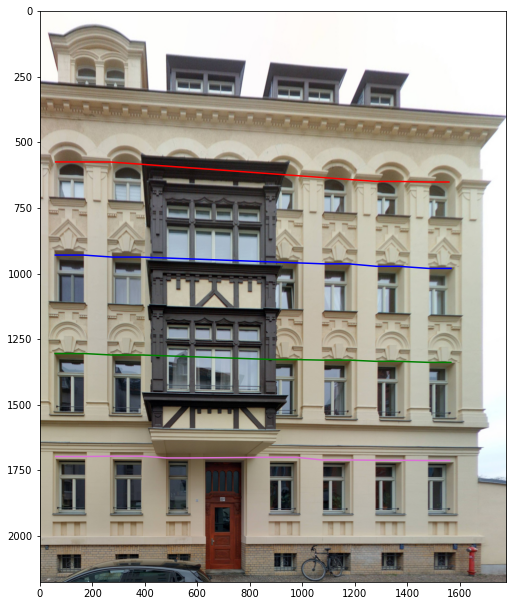

In [37]:
test_img_folder = "test-imgs/"
imgfilepath = test_img_folder + "OLD1.jpg"

floors, merged_lines = run_ransac_in_notebook(imgfilepath, window_class=window_class, gauben_class=gauben_class, dachfenster_class=dachfenster_class)
print("Number of floors: ", floors)

plot_floor_level_lines(imgfilepath, merged_lines)